In [2]:
import tensorflow as tf
from glob import glob
import numpy as np
import pickle
import json
import os
import random
import matplotlib.pyplot as plt

In [3]:
# only using CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
def save_data(output_path, mydata):
    with open(output_path, 'wb') as f:
        
        pickle.dump(mydata, f)
        
def load_data(data_path):
    data = pickle.load(open(data_path, 'rb'))

    return data

def convert_binary_score(severe_score):
    
    if severe_score >= 10:
        return 1
    else:
        return 0
    
def lower_filepath(filepath):
    
    filename, fileformat = filepath.split(".")
    fileformat = fileformat.lower()
    
    converted_filepath = filename + "." + fileformat
    
    return converted_filepath
    
def shuffle_data(mydata):
    mydata = np.array(mydata)
    idx = np.arange(len(mydata))
    random.shuffle(idx)
    
    return mydata[idx]
    
def filter_available_visits(amd_record_visit):
    
    filtered_visits = []
    
    for visit in amd_record_visit:
        re_label_test = False
        re_data_test = False
        le_label_test = False
        le_data_test = False
        
        try:
            this_re_severe_score = visit["AMDSEVRE"]
            if np.isnan(this_re_severe_score):
                re_label_test = False
            else:
                re_label_test = True
        except:
            continue
        
        try:
            this_le_severe_score = visit["AMDSEVLE"]
            if np.isnan(this_le_severe_score):
                le_label_test = False
            else:
                le_label_test = True
        except:
            continue
            
        try:
            this_re_data = visit["RE_IMG"]
            if len(this_re_data) > 0:
                re_data_test = True
            else:
                re_data_test = False
        except:
            continue
            
        try:
            this_le_data = visit["LE_IMG"]
            if len(this_le_data) > 0:
                le_data_test = True
            else:
                le_data_test = False
        except:
            continue
            
        test_result = re_label_test * le_label_test * re_data_test * le_data_test
        
        if test_result == 1:
            filtered_visits.append(visit)
            
    return filtered_visits

In [4]:
def build_patient_dict(data_dir, remove_recurrent=True):
    
    json_data = open(data_dir)
    amd_data = json.load(json_data)
    patient_dict = dict()
    
    count_idx = 0
    count_removed_patient = 0
    for idx, record in enumerate(amd_data):
        if idx % 100 == 0:
            print("{} patients processed...".format(count_idx*100))
            count_idx += 1
        
        this_id = record["ID2"]
        this_visits = record["VISITS"]
        filtered_visits = filter_available_visits(this_visits)
        this_re = dict()
        this_le = dict()
        
        re_year = []
        le_year = []
        re_img = []
        le_img = []
        re_severe_score = []
        le_severe_score = []
        re_late_amd = []
        le_late_amd = []
        
        if len(filtered_visits) == 0:
            count_removed_patient += 1
            continue
            
        for i, visit in enumerate(filtered_visits):
            
            re_year.append(int(visit["VISNO"])/2)
            le_year.append(int(visit["VISNO"])/2)
            re_img.append(lower_filepath(visit["RE_IMG"]))
            le_img.append(lower_filepath(visit["LE_IMG"]))
            re_severe_score.append(visit["AMDSEVRE"])
            le_severe_score.append(visit["AMDSEVLE"])
            re_late_amd.append(convert_binary_score(visit["AMDSEVRE"]))
            le_late_amd.append(convert_binary_score(visit["AMDSEVLE"]))
            
        re_late_amd = np.array(re_late_amd)
        le_late_amd = np.array(le_late_amd)
            
        if remove_recurrent:
            
            if np.sum(re_late_amd) > 0: # test whether the eye had late-amd status
                re_first_late_amd_idx = np.where(re_late_amd == 1)[0][0]
                re_year = re_year[:re_first_late_amd_idx+1]
                re_img = re_img[:re_first_late_amd_idx+1]
                re_severe_score = re_severe_score[:re_first_late_amd_idx+1]
                re_late_amd = re_late_amd[:re_first_late_amd_idx+1]
                
            if np.sum(le_late_amd) > 0: # test whether the eye had late-amd status
                le_first_late_amd_idx = np.where(le_late_amd == 1)[0][0]
                le_year = le_year[:le_first_late_amd_idx+1]
                le_img = le_img[:le_first_late_amd_idx+1]
                le_severe_score = le_severe_score[:le_first_late_amd_idx+1]
                le_late_amd = le_late_amd[:le_first_late_amd_idx+1]
        
        this_re["re_year"] = re_year
        this_re["re_img"] = re_img
        this_re["re_severe_score"] = re_severe_score
        this_re["re_late_amd"] = re_late_amd
        
        this_le["le_year"] = le_year
        this_le["le_img"] = le_img
        this_le["le_severe_score"] = le_severe_score
        this_le["le_late_amd"] = le_late_amd
        
        patient_dict[this_id] = {"re" : this_re, "le" : this_le}
    
    print("{} patients that have no valid visits were excluded".format(count_removed_patient))
    
    return patient_dict

In [5]:
patient_dict = build_patient_dict("/home/jl5307/current_research/AMD_prediction/data/AREDS_participants_amd3.json", remove_recurrent=True)

0 patients processed...
100 patients processed...
200 patients processed...
300 patients processed...
400 patients processed...
500 patients processed...
600 patients processed...
700 patients processed...
800 patients processed...
900 patients processed...
1000 patients processed...
1100 patients processed...
1200 patients processed...
1300 patients processed...
1400 patients processed...
1500 patients processed...
1600 patients processed...
1700 patients processed...
1800 patients processed...
1900 patients processed...
2000 patients processed...
2100 patients processed...
2200 patients processed...
2300 patients processed...
2400 patients processed...
2500 patients processed...
2600 patients processed...
2700 patients processed...
2800 patients processed...
2900 patients processed...
3000 patients processed...
3100 patients processed...
3200 patients processed...
3300 patients processed...
3400 patients processed...
3500 patients processed...
3600 patients processed...
3700 patients

In [7]:
# plot the distribution of late-AMD occurrence visit

In [6]:
def plot_late_amd_occurrence(patient_dict):
    
    patient_id_list = list(patient_dict.keys())
    late_amd_visit_list = []
    late_amd_eye_count = 0
    check_list = []
    
    for patient_id in patient_id_list:
        
        this_re = patient_dict[patient_id]["re"]
        this_le = patient_dict[patient_id]["le"]
        
        this_re_year = this_re["re_year"]
        this_le_year = this_le["le_year"]
        this_re_late_amd = this_re["re_late_amd"]
        this_le_late_amd = this_le["le_late_amd"]
        
        if this_re_late_amd[-1] == 1:
            late_amd_visit_list.append(this_re_year[-1])
            late_amd_eye_count += 1
            
            if this_re_year[-1] == 0:
                check_list.append(patient_id)
        
        if this_le_late_amd[-1] == 1:
            late_amd_visit_list.append(this_le_year[-1])
            late_amd_eye_count += 1
    
    print("total number of late-AMD eyes: {}".format(late_amd_eye_count))
    
    late_amd_visit_list = np.array(late_amd_visit_list)
    late_amd_visit, late_amd_visit_count = np.unique(late_amd_visit_list, return_counts=True)
    
    plt.bar(late_amd_visit, late_amd_visit_count)
    plt.xticks(late_amd_visit, late_amd_visit)
    plt.xlabel("visit year")
    plt.show()
    
    return late_amd_visit, late_amd_visit_count

total number of late-AMD eyes: 1834


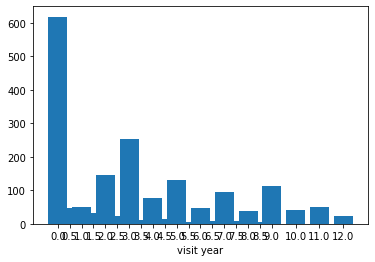

In [7]:
unique_year, visit_count = plot_late_amd_occurrence(patient_dict)

In [13]:
patient_dict["1012"]

{'re': {'re_year': [0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0],
  're_img': ['52140 QUA F2 RE LS.jpg',
   '52140 04 F2 RE LS.jpg',
   '52140 06 F2 RE LS.jpg',
   '52140 08 F2 RE LS.jpg',
   '52140 10 F2 RE LS.jpg',
   '52140 12 F2 RE LS.jpg',
   '52140 14 F2 RE LS.jpg',
   '52140 18 F2 RE LS.jpg',
   '52140 20 F2 RE LS.jpg'],
  're_severe_score': [1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  're_late_amd': array([0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'le': {'le_year': [0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0],
  'le_img': ['52140 QUA F2 LE LS.jpg',
   '52140 04 F2 LE LS.jpg',
   '52140 06 F2 LE LS.jpg',
   '52140 08 F2 LE LS.jpg',
   '52140 10 F2 LE LS.jpg',
   '52140 12 F2 LE LS.jpg',
   '52140 14 F2 LE LS.jpg',
   '52140 18 F2 LE LS.jpg',
   '52140 20 F2 LE LS.jpg'],
  'le_severe_score': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0],
  'le_late_amd': array([0, 0, 0, 0, 0, 0, 0, 0, 0])}}

In [10]:
# build dataset for 2-year prediction (one future timestamp) of binary label

In [21]:
def build_binary_prediction_data_dict(patient_dict, unique_year, timestamp_delta, train_size, validation_size, test_size, count=True):
    
    patient_id_list = list(patient_dict.keys())
    eye_data_dict = dict()
    late_amd_count = 0
    late_amd_eye_list = []
    non_late_amd_eye_list = []
    count_eyes_with_insufficient_visit = 0 
    
    for patient_id in patient_id_list:
        
        this_re = patient_dict[patient_id]["re"]
        this_le = patient_dict[patient_id]["le"]
        
        this_re_year = this_re["re_year"]
        this_le_year = this_le["le_year"]
        this_re_late_amd = this_re["re_late_amd"] # binary scores 
        this_le_late_amd = this_le["le_late_amd"] # binary scores 
        this_re_img_list = this_re["re_img"]
        this_le_img_list = this_le["le_img"]
        re_record_len = this_re_year[-1] - this_re_year[0]
        le_record_len = this_le_year[-1] - this_le_year[0]
        
        if re_record_len >= timestamp_delta:
            this_re_last_label = this_re_late_amd[-1]
            this_re_dict = {"year" : this_re_year, "visits" : this_re_img_list, "labels" : this_re_late_amd}
    
            if this_re_last_label == 1:
                late_amd_count += 1
                late_amd_eye_list.append(this_re_dict)
            else:
                non_late_amd_eye_list.append(this_re_dict)
        else:
            count_eyes_with_insufficient_visit += 1
            
        if le_record_len >= timestamp_delta:
            this_le_last_label = this_le_late_amd[-1]
            this_le_dict = {"year" : this_le_year, "visits" : this_le_img_list, "labels" : this_le_late_amd}
    
            if this_le_last_label == 1:
                late_amd_count += 1
                late_amd_eye_list.append(this_le_dict)
            else:
                non_late_amd_eye_list.append(this_le_dict)
        else:
            count_eyes_with_insufficient_visit += 1
    
    if count:
        print("total number of eyes in the dataset: {}".format(len(patient_id_list)*2-count_eyes_with_insufficient_visit))
        print("{} eyes were excluded due to insufficient visits".format(count_eyes_with_insufficient_visit))
        print("the number of eyes having late-amd status: {}".format(late_amd_count))
        
    # train, validation, test set
    late_amd_eye_list = shuffle_data(late_amd_eye_list)
    non_late_amd_eye_list = shuffle_data(non_late_amd_eye_list)
    
    ## train set
    train_late_amd_eyes_list = late_amd_eye_list[:int(np.floor(len(late_amd_eye_list)*train_size))]
    train_non_late_amd_eyes_list = non_late_amd_eye_list[:int(np.floor(len(non_late_amd_eye_list)*train_size))]
    
    ## test and validation set
    test_validation_late_amd_eyes_list = late_amd_eye_list[int(np.floor(len(late_amd_eye_list)*train_size)):]
    test_validation_non_late_amd_eyes_list = non_late_amd_eye_list[int(np.floor(len(non_late_amd_eye_list)*train_size)):]
    
    test_late_amd_eyes_list = test_validation_late_amd_eyes_list[:int(np.floor(len(test_validation_late_amd_eyes_list) * (test_size / (validation_size+test_size))))]
    test_non_late_amd_eyes_list = test_validation_non_late_amd_eyes_list[:int(np.floor(len(test_validation_non_late_amd_eyes_list) * (test_size / (validation_size+test_size))))]
    
    validation_late_amd_eyes_list = test_validation_late_amd_eyes_list[int(np.floor(len(test_validation_late_amd_eyes_list) * (test_size / (validation_size+test_size)))):]
    validation_non_late_amd_eyes_list = test_validation_non_late_amd_eyes_list[int(np.floor(len(test_validation_non_late_amd_eyes_list) * (test_size / (validation_size+test_size)))):]
    
    train_amd_eyes = []
    validation_amd_eyes = []
    test_amd_eyes = []
    
    train_amd_eyes.extend(train_late_amd_eyes_list)
    train_amd_eyes.extend(train_non_late_amd_eyes_list)
    validation_amd_eyes.extend(validation_late_amd_eyes_list)
    validation_amd_eyes.extend(validation_non_late_amd_eyes_list)
    test_amd_eyes.extend(test_late_amd_eyes_list)
    test_amd_eyes.extend(test_non_late_amd_eyes_list)
    
    train_amd_eyes = shuffle_data(train_amd_eyes)
    validation_amd_eyes = shuffle_data(validation_amd_eyes)
    test_amd_eyes = shuffle_data(test_amd_eyes)
    
    # build training and validation data dict
    
    train_eye_dict = dict()
    validation_eye_dict = dict()

    for eye in train_amd_eyes:
        this_eye_years = np.array(eye["year"])
        this_eye_visits = eye["visits"]
        this_eye_labels = np.array(eye["labels"])
        
        for idx, year in enumerate(this_eye_years):
            eye_img = this_eye_visits[idx]
            label_year = year + timestamp_delta
            label_ind1 = np.where(this_eye_years > year, True, False)
            label_ind2 = np.where(this_eye_years <= label_year, True, False)
            label_ind = label_ind1 * label_ind2
            
            if np.sum(label_ind) > 0:
                train_eye_dict[eye_img] = int(np.max(this_eye_labels[label_ind]))
            else:
                continue

    for eye in validation_amd_eyes:
        this_eye_years = np.array(eye["year"])
        this_eye_visits = eye["visits"]
        this_eye_labels = np.array(eye["labels"])
        
        for idx, year in enumerate(this_eye_years):
            eye_img = this_eye_visits[idx]
            label_year = year + timestamp_delta
            label_ind1 = np.where(this_eye_years > year, True, False)
            label_ind2 = np.where(this_eye_years <= label_year, True, False)
            label_ind = label_ind1 * label_ind2
            
            if np.sum(label_ind) > 0:
                validation_eye_dict[eye_img] = int(np.max(this_eye_labels[label_ind]))
            else:
                continue
                
    # build test data dict evaluated within timedelta
    
    test_eye_dict = dict()
    for y in unique_year:
        test_eye_dict[y] = dict()
        
    for eye in test_amd_eyes:
        this_eye_years = np.array(eye["year"])
        this_eye_visits = eye["visits"]
        this_eye_labels = np.array(eye["labels"])
        
        for idx, year in enumerate(this_eye_years):
            eye_img = this_eye_visits[idx]
            label_year = year + timestamp_delta
            label_ind1 = np.where(this_eye_years > year, True, False)
            label_ind2 = np.where(this_eye_years <= label_year, True, False)
            label_ind = label_ind1 * label_ind2
            
            if np.sum(label_ind) > 0:
                test_eye_dict[int(year)][eye_img] = int(np.max(this_eye_labels[label_ind]))
            else:
                continue
                
    return {"train_set" : train_eye_dict, "validation_set" : validation_eye_dict, "test_set" : test_eye_dict}

In [22]:
eye_data_dict_timedelta2 = build_binary_prediction_data_dict(patient_dict, unique_year, timestamp_delta=2, train_size=0.7, validation_size=0.15, test_size=0.15, count=True)

total number of eyes in the dataset: 7661
1469 eyes were excluded due to insufficient visits
the number of eyes having late-amd status: 844


In [17]:
# count number of labels in each dataset

In [23]:
def count_label(eye_dict, return_result=False):
    
    late_amd_count = 0
    non_late_amd_count = 0
    
    for eye_img, label in eye_dict.items():
        if label == 1:
            late_amd_count += 1
        else:
            non_late_amd_count += 1
    
    if return_result:
        return late_amd_count, non_late_amd_count
    else:
        print("the number of late-AMD label: {}".format(late_amd_count))
        print("the number of non late-AMD label: {}".format(non_late_amd_count))

In [24]:
count_label(eye_data_dict_timedelta2["train_set"])

the number of late-AMD label: 772
the number of non late-AMD label: 33056


In [25]:
count_label(eye_data_dict_timedelta2["validation_set"])

the number of late-AMD label: 186
the number of non late-AMD label: 6971


In [30]:
def count_label_by_group(eye_dict):
    
    groups = []
    late_amd_count_list = []
    non_late_amd_count_list = []
    
    for key, value in eye_dict.items():
        if len(value) > 0:
            groups.append(key)
            this_group_late_amd_count, this_group_non_late_amd_count = count_label(value, return_result=True)
            late_amd_count_list.append(this_group_late_amd_count)
            non_late_amd_count_list.append(this_group_non_late_amd_count)
        else:
            continue
    
    x = np.arange(len(groups))  # the label locations
    width = 0.5  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, non_late_amd_count_list, width, label='non late-AMD')
    rects2 = ax.bar(x + width/2, late_amd_count_list, width, label='late-AMD')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('count')
    ax.set_xlabel('visit timestamp')
    #ax.set_title('Scores by group and gender')
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation="vertical")
    ax.legend()

    fig.tight_layout()
    
    return groups, late_amd_count_list, non_late_amd_count_list

([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0],
 [14, 5, 31, 32, 16, 17, 10, 15, 7, 8, 8, 4],
 [980, 55, 913, 966, 811, 849, 641, 577, 421, 453, 278, 90])

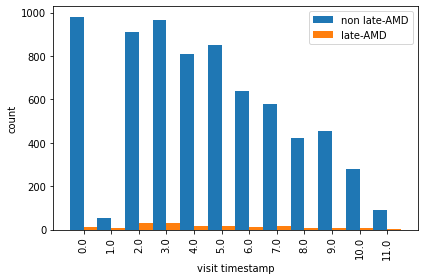

In [31]:
count_label_by_group(eye_data_dict_timedelta2["test_set"])

In [32]:
save_data("/home/jl5307/current_research/AMD_prediction/img_data/img_data_dict/eye_data_dict_timedelta2.pkl", eye_data_dict_timedelta2)

In [ ]:
# build dataset for ConvRNN

In [8]:
def build_longitudinal_prediction_data_dict(patient_dict, unique_year, timestamp_delta, train_size, validation_size, test_size, count=True):
    
    patient_id_list = list(patient_dict.keys())
    eye_data_dict = dict()
    late_amd_count = 0
    late_amd_eye_list = []
    non_late_amd_eye_list = []
    count_eyes_with_insufficient_visit = 0 
    
    for patient_id in patient_id_list:
        
        this_re = patient_dict[patient_id]["re"]
        this_le = patient_dict[patient_id]["le"]
        
        this_re_year = this_re["re_year"]
        this_le_year = this_le["le_year"]
        this_re_late_amd = this_re["re_late_amd"] # binary scores 
        this_le_late_amd = this_le["le_late_amd"] # binary scores 
        this_re_img_list = this_re["re_img"]
        this_le_img_list = this_le["le_img"]
        re_record_len = this_re_year[-1] - this_re_year[0]
        le_record_len = this_le_year[-1] - this_le_year[0]
        
        if re_record_len >= timestamp_delta:
            this_re_last_label = this_re_late_amd[-1]
            this_re_dict = {"year" : this_re_year, "visits" : this_re_img_list, "labels" : this_re_late_amd}
    
            if this_re_last_label == 1:
                late_amd_count += 1
                late_amd_eye_list.append(this_re_dict)
            else:
                non_late_amd_eye_list.append(this_re_dict)
        else:
            count_eyes_with_insufficient_visit += 1
            
        if le_record_len >= timestamp_delta:
            this_le_last_label = this_le_late_amd[-1]
            this_le_dict = {"year" : this_le_year, "visits" : this_le_img_list, "labels" : this_le_late_amd}
    
            if this_le_last_label == 1:
                late_amd_count += 1
                late_amd_eye_list.append(this_le_dict)
            else:
                non_late_amd_eye_list.append(this_le_dict)
        else:
            count_eyes_with_insufficient_visit += 1
    
    if count:
        print("total number of eyes in the dataset: {}".format(len(patient_id_list)*2-count_eyes_with_insufficient_visit))
        print("{} eyes were excluded due to insufficient visits".format(count_eyes_with_insufficient_visit))
        print("the number of eyes having late-amd status: {}".format(late_amd_count))
        
    # train, validation, test set
    late_amd_eye_list = shuffle_data(late_amd_eye_list)
    non_late_amd_eye_list = shuffle_data(non_late_amd_eye_list)
    
    ## train set
    train_late_amd_eyes_list = late_amd_eye_list[:int(np.floor(len(late_amd_eye_list)*train_size))]
    train_non_late_amd_eyes_list = non_late_amd_eye_list[:int(np.floor(len(non_late_amd_eye_list)*train_size))]
    
    ## test and validation set
    test_validation_late_amd_eyes_list = late_amd_eye_list[int(np.floor(len(late_amd_eye_list)*train_size)):]
    test_validation_non_late_amd_eyes_list = non_late_amd_eye_list[int(np.floor(len(non_late_amd_eye_list)*train_size)):]
    
    test_late_amd_eyes_list = test_validation_late_amd_eyes_list[:int(np.floor(len(test_validation_late_amd_eyes_list) * (test_size / (validation_size+test_size))))]
    test_non_late_amd_eyes_list = test_validation_non_late_amd_eyes_list[:int(np.floor(len(test_validation_non_late_amd_eyes_list) * (test_size / (validation_size+test_size))))]
    
    validation_late_amd_eyes_list = test_validation_late_amd_eyes_list[int(np.floor(len(test_validation_late_amd_eyes_list) * (test_size / (validation_size+test_size)))):]
    validation_non_late_amd_eyes_list = test_validation_non_late_amd_eyes_list[int(np.floor(len(test_validation_non_late_amd_eyes_list) * (test_size / (validation_size+test_size)))):]
    
    train_amd_eyes = []
    validation_amd_eyes = []
    test_amd_eyes = []
    
    train_amd_eyes.extend(train_late_amd_eyes_list)
    train_amd_eyes.extend(train_non_late_amd_eyes_list)
    validation_amd_eyes.extend(validation_late_amd_eyes_list)
    validation_amd_eyes.extend(validation_non_late_amd_eyes_list)
    test_amd_eyes.extend(test_late_amd_eyes_list)
    test_amd_eyes.extend(test_non_late_amd_eyes_list)
    
    train_amd_eyes = shuffle_data(train_amd_eyes)
    validation_amd_eyes = shuffle_data(validation_amd_eyes)
    test_amd_eyes = shuffle_data(test_amd_eyes)
    
    # build training and validation data dict
    
    train_eye_dict = dict()
    validation_eye_dict = dict()
    
    train_eye_list = []
    train_label_list = []
    validation_eye_list = []
    validation_label_list = []

    for eye in train_amd_eyes:
        this_eye_years = np.array(eye["year"])
        this_eye_visits = eye["visits"]
        this_eye_labels = np.array(eye["labels"])
        
        for idx, year in enumerate(this_eye_years):
            eye_img_list = this_eye_visits[:(idx+1)]
            label_year = year + timestamp_delta
            label_ind1 = np.where(this_eye_years > year, True, False)
            label_ind2 = np.where(this_eye_years <= label_year, True, False)
            label_ind = label_ind1 * label_ind2
            
            if np.sum(label_ind) > 0:
                train_eye_list.append(eye_img_list)
                train_label_list.append(int(np.max(this_eye_labels[label_ind])))
            else:
                continue
                
    train_eye_dict["eye_list"] = train_eye_list
    train_eye_dict["label_list"] = train_label_list
    
    for eye in validation_amd_eyes:
        this_eye_years = np.array(eye["year"])
        this_eye_visits = eye["visits"]
        this_eye_labels = np.array(eye["labels"])
        
        for idx, year in enumerate(this_eye_years):
            eye_img_list = this_eye_visits[:(idx+1)]
            label_year = year + timestamp_delta
            label_ind1 = np.where(this_eye_years > year, True, False)
            label_ind2 = np.where(this_eye_years <= label_year, True, False)
            label_ind = label_ind1 * label_ind2
            
            if np.sum(label_ind) > 0:
                validation_eye_list.append(eye_img_list)
                validation_label_list.append(int(np.max(this_eye_labels[label_ind])))
            else:
                continue
                
    validation_eye_dict["eye_list"] = validation_eye_list
    validation_eye_dict["label_list"] = validation_label_list
    
    # build test data dict evaluated within timedelta
    
    test_eye_dict = dict()
    for y in unique_year:
        test_eye_dict[y] = dict()
        test_eye_dict[y]["eye_list"] = []
        test_eye_dict[y]["label_list"] = []
        
    for eye in test_amd_eyes:
        this_eye_years = np.array(eye["year"])
        this_eye_visits = eye["visits"]
        this_eye_labels = np.array(eye["labels"])
        
        for idx, year in enumerate(this_eye_years):
            eye_img_list = this_eye_visits[:(idx+1)]
            label_year = year + timestamp_delta
            label_ind1 = np.where(this_eye_years > year, True, False)
            label_ind2 = np.where(this_eye_years <= label_year, True, False)
            label_ind = label_ind1 * label_ind2
            
            if np.sum(label_ind) > 0:
                test_eye_dict[int(year)]["eye_list"].append(eye_img_list)
                test_eye_dict[int(year)]["label_list"].append(int(np.max(this_eye_labels[label_ind])))
            else:
                continue
       
    return {"train_set" : train_eye_dict, "validation_set" : validation_eye_dict, "test_set" : test_eye_dict}

In [9]:
longitudinal_eye_data_dict_timedelta2 = build_longitudinal_prediction_data_dict(patient_dict, unique_year, timestamp_delta=2, train_size=0.7, validation_size=0.15, test_size=0.15, count=True)

total number of eyes in the dataset: 7661
1469 eyes were excluded due to insufficient visits
the number of eyes having late-amd status: 844


In [10]:
longitudinal_eye_data_dict_timedelta2["train_set"]

{'eye_list': [['53865 QUA F2 RE LS.jpg'],
  ['53865 QUA F2 RE LS.jpg', '53865 04 F2 RE LS.jpg'],
  ['53865 QUA F2 RE LS.jpg', '53865 04 F2 RE LS.jpg', '53865 06 F2 RE LS.jpg'],
  ['53865 QUA F2 RE LS.jpg',
   '53865 04 F2 RE LS.jpg',
   '53865 06 F2 RE LS.jpg',
   '53865 08 F2 RE LS.jpg'],
  ['53865 QUA F2 RE LS.jpg',
   '53865 04 F2 RE LS.jpg',
   '53865 06 F2 RE LS.jpg',
   '53865 08 F2 RE LS.jpg',
   '53865 10 F2 RE LS.jpg'],
  ['53865 QUA F2 RE LS.jpg',
   '53865 04 F2 RE LS.jpg',
   '53865 06 F2 RE LS.jpg',
   '53865 08 F2 RE LS.jpg',
   '53865 10 F2 RE LS.jpg',
   '53865 14 F2 RE LS.jpg'],
  ['53865 QUA F2 RE LS.jpg',
   '53865 04 F2 RE LS.jpg',
   '53865 06 F2 RE LS.jpg',
   '53865 08 F2 RE LS.jpg',
   '53865 10 F2 RE LS.jpg',
   '53865 14 F2 RE LS.jpg',
   '53865 16 F2 RE LS.jpg'],
  ['53865 QUA F2 RE LS.jpg',
   '53865 04 F2 RE LS.jpg',
   '53865 06 F2 RE LS.jpg',
   '53865 08 F2 RE LS.jpg',
   '53865 10 F2 RE LS.jpg',
   '53865 14 F2 RE LS.jpg',
   '53865 16 F2 RE LS.jpg',
  

In [11]:
len(longitudinal_eye_data_dict_timedelta2["train_set"])

2

In [72]:
def count_label_longitudinal(eye_dict, return_result=False):
    
    late_amd_count = np.sum(eye_dict["label_list"])
    non_late_amd_count = len(eye_dict["label_list"]) - late_amd_count
    
    if return_result:
        return late_amd_count, non_late_amd_count
    else:
        print("the number of late-AMD label: {}".format(late_amd_count))
        print("the number of non late-AMD label: {}".format(non_late_amd_count))
        
def count_length_distribution(eye_dict):

    length_list = []
    
    for e in eye_dict["eye_list"]:
        length_list.append(len(e))
        
    unique_length = set(length_list)
    
    print("Median length: {}".format(np.median(length_list)))
        
    plt.hist(length_list, bins=len(unique_length))

In [48]:
count_label_longitudinal(longitudinal_eye_data_dict_timedelta2["train_set"])

the number of late-AMD label: 789
the number of non late-AMD label: 32911


In [49]:
count_label_longitudinal(longitudinal_eye_data_dict_timedelta2["validation_set"])

the number of late-AMD label: 167
the number of non late-AMD label: 7187


Median length: 4.0


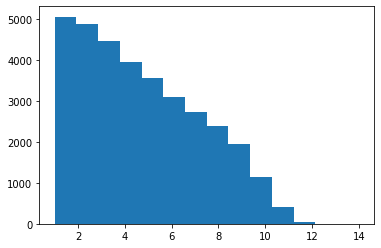

In [73]:
count_length_distribution(longitudinal_eye_data_dict_timedelta2["train_set"])

Median length: 4.0


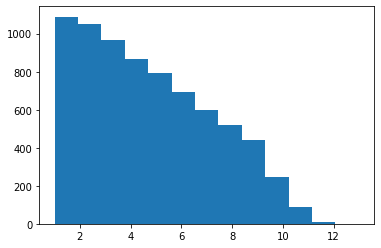

In [74]:
count_length_distribution(longitudinal_eye_data_dict_timedelta2["validation_set"])

In [12]:
save_data("/home/jl5307/current_research/AMD_prediction/img_data/img_data_dict/longitudinal_eye_data_dict_timedelta2.pkl", longitudinal_eye_data_dict_timedelta2)

In [ ]:
# convert longitudinal timedelta data dictionary to timedelta dictionary

In [9]:
def convert_longitudinal_to_prediction_dict(longitudinal_eye_data_dict):
    
    train_eye_list = longitudinal_eye_data_dict["train_set"]["eye_list"]
    train_label_list = longitudinal_eye_data_dict["train_set"]["label_list"]
    validation_eye_list = longitudinal_eye_data_dict["validation_set"]["eye_list"]
    validation_label_list = longitudinal_eye_data_dict["validation_set"]["label_list"]
    
    train_eye_dict = dict()
    validation_eye_dict = dict()
    
    for eye_list, label in zip(train_eye_list, train_label_list):
        target_eye = eye_list[-1]
        train_eye_dict[target_eye] = label
        
    for eye_list, label in zip(validation_eye_list, validation_label_list):
        target_eye = eye_list[-1]
        validation_eye_dict[target_eye] = label
    
    longitudinal_test_eye_dict = longitudinal_eye_data_dict["test_set"]
    unique_year = list(longitudinal_eye_data_dict["test_set"].keys())
    test_eye_dict = dict()
    
    for y in unique_year:
        test_eye_dict[y] = dict()
    
    for year, value in longitudinal_test_eye_dict.items():
        this_year_eye_list = value["eye_list"]
        this_year_label_list = value["label_list"]
        
        for eye_list, label in zip(this_year_eye_list, this_year_label_list):
            target_eye = eye_list[-1]
            test_eye_dict[year][target_eye] = label
            
    return {"train_set" : train_eye_dict, "validation_set" : validation_eye_dict, "test_set" : test_eye_dict}

In [10]:
longitudinal_eye_data_dict_timedelta2 = load_data("/home/jl5307/current_research/AMD_prediction/img_data/img_data_dict/longitudinal_eye_data_dict_timedelta2.pkl")

In [24]:
eye_data_dict_timedelta2 = convert_longitudinal_to_prediction_dict(longitudinal_eye_data_dict_timedelta2)

In [25]:
save_data("/home/jl5307/current_research/AMD_prediction/img_data/img_data_dict/within2yrs_eye_data_dict_timedelta2.pkl", eye_data_dict_timedelta2)